In [1]:
from utils.dataset import set_b_dataset, set_b_dataclass
from utils.model import ResNet10
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import torchvision
import torchvision.models as models
from random import sample
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler


PROJECT_DIR = '/Users/nattapolchanpaisit/Documents/GitHub/Algorithm/SC1015-PROJECT/'
N_TRAIN = 300
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
BATCH_SIZE = 32
EPOCH = 10
F_LOW = 200
F_HIGH = 600
DROPOUT = 0.2

assert not (F_HIGH-F_LOW) % 8, "Frequency range should be divisible by 8"

train_id = tuple(sample([i for i in range(461)], N_TRAIN))
# train_id = tuple([i for i in range(N_TRAIN)])
test_id = tuple(set([i for i in range(461)])-set(train_id))
writer = SummaryWriter(f'runs/{F_LOW}_{F_HIGH}_Hz')
trainset = set_b_dataclass(PROJECT_DIR, output_width=200, list_id=train_id, stft_low=F_LOW, stft_high=F_HIGH, oversample=True)
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
testset = set_b_dataclass(PROJECT_DIR, output_width=200, list_id=test_id, stft_low=F_LOW, stft_high=F_HIGH)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True)

# model = torchvision.models.resnet18(False)
# model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
# model.fc = torch.nn.Linear(512, 3)

model = ResNet10(dropout=DROPOUT)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

/Users/nattapolchanpaisit/miniforge3/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/nattapolchanpaisit/miniforge3/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.8.dylib
  Referenced from: <BE0CCD9A-269A-30E2-A23C-DA45E89EBB1F> /Users/nattapolchanpaisit/miniforge3/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/nattapolchanpaisit/miniforge3/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/Users/nattapolchanpaisit/miniforge3/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/Users/nattapolchanpaisit/miniforge3/lib/python3.10/lib-dynload/../../libjpeg.8.dylib' (no such file), '/Users/nattapolchanpaisit/miniforge3/bin/../lib/libjpeg.8.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS@rpath/libjpeg.8.dylib' (no such file), '/Users/nattapolchanpaisit/miniforge3/li

In [2]:
def images_to_probs(model, image, idx):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    image = image[idx][0].view(1,1,output.size(1), output.size(2))
    output = model(image)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    classes = ['normal', 'murmur', 'extrastole']
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        pred, prob = images_to_probs(net, images, idx)
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        ax.imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[pred],
            prob * 100.0,
            classes[labels[idx]]),
                    color=("green" if pred==labels[idx].item() else "red"))
    return fig

In [3]:
def train_cnn_stft():
    for epoch in range(EPOCH):
        running_loss = 0
        running_val_loss = 0
        running_val_acc = 0
        running_acc = 0
        total_murmur_acc = 0
        running_murmur_acc = 0
        for i, data in enumerate(trainloader):
            stft, labels = data
            stft = stft.to(torch.float32).to(DEVICE)
            stft = stft.view(-1, 1, stft.size(1), stft.size(2))
            label_one_hot = F.one_hot(labels, num_classes=3).to(torch.float32).to(DEVICE)
            model.train(True)
            grid = torchvision.utils.make_grid(stft)
            optimizer.zero_grad()
            outputs_one_hot = model(stft)
            outputs_one_hot = nn.Softmax()(outputs_one_hot)
            loss = torch.nn.CrossEntropyLoss()(label_one_hot, outputs_one_hot)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            model.train(False)
            output_labels = torch.argmax(outputs_one_hot, 1)
            running_acc += torch.sum(output_labels==labels)
            
        for i, data in enumerate(testloader):
            writer.add_image('image', grid, 0)
            writer.add_graph(model, stft)
            writer.close()
            stft, labels = data
            stft = stft.to(torch.float32).to(DEVICE)
            stft = stft.view(-1, 1, stft.size(1), stft.size(2))
            label_one_hot = F.one_hot(labels, num_classes=3).to(torch.float32).to(DEVICE)
            outputs_one_hot = model(stft)
            outputs_one_hot = nn.Softmax()(outputs_one_hot)
            loss = torch.nn.CrossEntropyLoss()(label_one_hot, outputs_one_hot)
            running_val_loss += loss.item()
            output_labels = torch.argmax(outputs_one_hot, 1)
            running_val_acc += torch.sum(output_labels==labels)
            running_murmur_acc += torch.sum(labels.ge(1.0) * labels.le(1.1) * output_labels.ge(1.0) * output_labels.le(1.1))
            total_murmur_acc += torch.sum(labels==torch.ones(size=(labels.size())) * 1)
            
        print(f'{epoch} : Train Loss', running_loss/trainset.__len__())
        print(f' : Train Accuracy', running_acc/trainset.__len__())
        print(f' : Validation Loss', running_val_loss/testset.__len__())
        print(f' : Validation Accuracy', running_val_acc/testset.__len__())
        print(f' : Validation Accuracy (Murmur)', running_murmur_acc/total_murmur_acc)
        
        writer.add_scalar('Loss/train',
                            running_loss / trainset.__len__(),
                            epoch * len(trainloader))
        writer.add_scalar('Loss/val',
                            running_val_loss / testset.__len__(),
                            epoch * len(trainloader))
        writer.add_scalar('Accuracy/train',
                            running_acc / trainset.__len__(),
                            epoch * len(trainloader))
        writer.add_scalar('Accuracy/val',
                            running_val_loss / testset.__len__(),
                            epoch * len(trainloader))
        
        # writer.add_figure('predictions vs. actuals',
        #                     plot_classes_preds(model, testset, labels),
        #                     global_step=epoch * len(trainloader) + i)

In [4]:
print(trainset.count_class)
print(testset.count_class)

   count                                              index       label
0    212  [138, 139, 140, 141, 142, 143, 144, 145, 146, ...      normal
1    122  [54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 6...      murmur
2     54  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...  extrastole
   count                                              index       label
0    108  [86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 9...      normal
1     68  [38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 4...      murmur
2     38  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...  extrastole


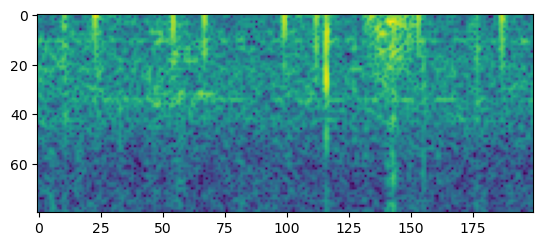

tensor([[0.3332, 0.3335, 0.3333]], grad_fn=<SoftmaxBackward0>)
murmur


/var/folders/mk/w2mwvrjn5sn9g2fty5rrgzd40000gn/T/ipykernel_78544/2862398425.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  b = nn.Softmax()(b)


In [7]:
i = 38
a = testset[i][0].view(1, 1, 80, 200)
plt.imshow(a[0,0])
plt.show()
b = model(a)
b = nn.Softmax()(b)
print(b)
print(testset.labels[i])

In [8]:
train_cnn_stft()

/var/folders/mk/w2mwvrjn5sn9g2fty5rrgzd40000gn/T/ipykernel_78544/2270689794.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs_one_hot = nn.Softmax()(outputs_one_hot)
/var/folders/mk/w2mwvrjn5sn9g2fty5rrgzd40000gn/T/ipykernel_78544/2270689794.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs_one_hot = nn.Softmax()(outputs_one_hot)


0 : Train Loss 0.04066547874322871
 : Train Accuracy tensor(0.3170)
 : Validation Loss 0.03973227237986627
 : Validation Accuracy tensor(0.5654)
 : Validation Accuracy (Murmur) tensor(0.4412)
1 : Train Loss 0.03983257388331227
 : Train Accuracy tensor(0.3144)
 : Validation Loss 0.0395165993788532
 : Validation Accuracy tensor(0.4907)
 : Validation Accuracy (Murmur) tensor(0.8824)
2 : Train Loss 0.038440090479310025
 : Train Accuracy tensor(0.3144)
 : Validation Loss 0.03759593050056529
 : Validation Accuracy tensor(0.3271)
 : Validation Accuracy (Murmur) tensor(1.)
3 : Train Loss 0.036507679936812094
 : Train Accuracy tensor(0.3144)
 : Validation Loss 0.03797959891435142
 : Validation Accuracy tensor(0.4019)
 : Validation Accuracy (Murmur) tensor(0.8824)
4 : Train Loss 0.035618043898307174
 : Train Accuracy tensor(0.3144)
 : Validation Loss 0.03750912886913692
 : Validation Accuracy tensor(0.3271)
 : Validation Accuracy (Murmur) tensor(1.)


KeyboardInterrupt: 